In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns 
%matplotlib inline

# Импорт библиотеки для кодирования
import category_encoders as ce

# Импорт специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif

# Импорт библиотек для преобразования признаков
import string
import spacy

# Импорт библиотек для преобразования признаков
import string
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


# Импорт библиотек для обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [23]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [24]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [25]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [26]:
# Посмотрим на тренировочные данные
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [27]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [28]:
#Посмотрим на тестовые данные 

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [29]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [30]:
# Наш сабминшн

sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [31]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [32]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## 1. Проработаем признаки. Очистка, преобразование . Удаление

1.1 Адрес отеля. Страна Национальность рецендента

In [34]:
display(data['hotel_address'])

0                        Via Senigallia 6 20161 Milan Italy
1         Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...
2               Mallorca 251 Eixample 08008 Barcelona Spain
3         Piazza Della Repubblica 17 Central Station 201...
4         Singel 303 309 Amsterdam City Center 1012 WJ A...
                                ...                        
515733    9 Knaresborough Place Kensington and Chelsea L...
515734    Landstra er Hauptstra e 155 03 Landstra e 1030...
515735    29 31 Gower Street Camden London WC1E 6HG Unit...
515736    31 Great Cumberland Place Westminster Borough ...
515737    25 Courtfield Gardens Kensington and Chelsea L...
Name: hotel_address, Length: 515738, dtype: object

In [35]:
# рассчитаем кол-во стран в нашем датасэте
# Предположим что страна - это последнее слово в строке с адресом , исключение - United Kingdom

def get_country(adress):
    
    if 'United Kingdom' in adress:
        return 'United Kingdom'
    else:
        word_list = adress.split(' ')
        return word_list[-1]

data['country'] = data['hotel_address'].apply(get_country)


data['country'].value_counts()

# У нас всего 6 стран 



United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country, dtype: int64

In [36]:
# Считаю, что единственное из адреса , что может коррелировать или как то влиять на оценку рецензента , 
# - это его национальность (reviewer_nationality)
# создаем признак указывающий на совпадение страны отеля и человека оставившего отзыв

def contry_of_reviewer(row):
    if row['reviewer_nationality'] in row['hotel_address']:
        return 1
    else:
        return 0
data['reviewer_nationality_hotel_country'] = data[['reviewer_nationality', 'hotel_address']].apply(contry_of_reviewer, axis=1)

data['reviewer_nationality_hotel_country'].value_counts()


0    515215
1       523
Name: reviewer_nationality_hotel_country, dtype: int64

<AxesSubplot:title={'center':'reviewer_nationality_hotel_country'}, xlabel='reviewer_nationality_hotel_country'>

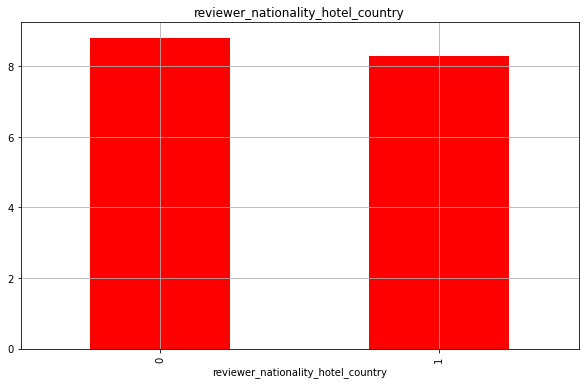

In [37]:
data_train = data[data['sample'] == 1]
pivot_data = data_train.groupby('reviewer_nationality_hotel_country')['reviewer_score'].median()

pivot_data.plot(
    kind='bar',
    figsize=(10, 6),
    title='reviewer_nationality_hotel_country',
    grid = True,
    color = 'red'

)
#  там где рецендент отдыхает на родине оценка немного ниже 

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
                               ...  
 Comoros                           1
 Anguilla                          1
 Tuvalu                            1
 Cape Verde                        1
 Palau                             1
Name: reviewer_nationality, Length: 227, dtype: int64

<AxesSubplot:>

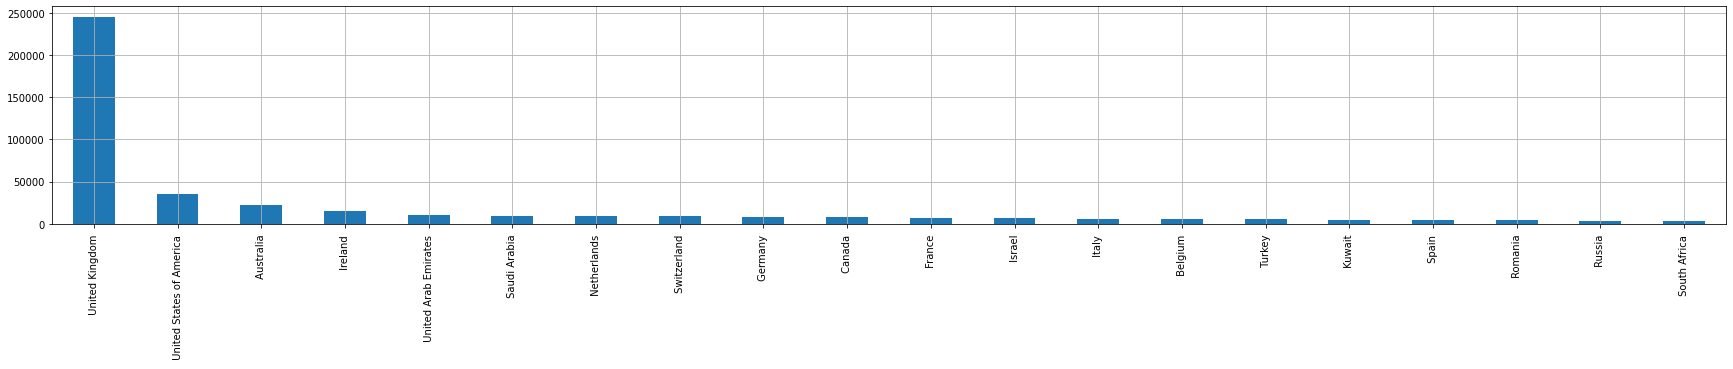

In [38]:
# посмотрим на самые популярные национальности
display(data['reviewer_nationality'].value_counts())

grouped_nationality = data['reviewer_nationality'].value_counts()
grouped_nationality = grouped_nationality.nlargest(20)
grouped_nationality.plot(
    kind='bar',
    grid=True,
    figsize=(30, 4)
)



In [39]:
# сократим кол-во национальностей до 20 популярных

#nationality_list = data['reviewer_nationality'].value_counts().nlargest(20)
#data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in nationality_list else 'other')
#data['reviewer_nationality'].value_counts()

In [40]:
# закодируем национальность


#ord_encoder = ce.OrdinalEncoder()
#data_bin = ord_encoder.fit_transform(data[['reviewer_nationality']])
#data = pd.concat([data, data_bin], axis=1)

bin_encoder = ce.BinaryEncoder(data[['reviewer_nationality']]) 
data_bin = bin_encoder.fit_transform(data[['reviewer_nationality']])
clothing = pd.concat([data, data_bin], axis=1)

In [41]:
# закодируем страну


#ord_encoder = ce.OrdinalEncoder()
#data_bin = ord_encoder.fit_transform(data[['country']])
#data = pd.concat([data, data_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['country'], use_cat_names=True) 
data_bin = encoder.fit_transform(data[['country']])
data = pd.concat([data, data_bin], axis=1)

In [42]:
# закодируем названия отелей
bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) 
hotel_name_bin = bin_encoder.fit_transform(data['hotel_name'])
data = pd.concat([data, hotel_name_bin], axis=1)

#ord_encoder = ce.OrdinalEncoder()
#data_bin = ord_encoder.fit_transform(data[['hotel_name']])
#data = pd.concat([data, data_bin], axis=1)


1.2 Признаки даты и времени

In [43]:
data['review_date'] = pd.to_datetime(data['review_date'])

In [44]:
# создадим столбец с годом review date
data['review_date_year'] = data['review_date'].dt.year

In [45]:
# создадим столбец с месяцем review date
data['review_date_month'] = data['review_date'].dt.month

In [46]:
# преобразуем в числовой формат days_since_review

data['days_since_review'] = data['days_since_review']
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split(' ')[0])) 

data['days_since_review'].value_counts()

1      2585
322    2308
120    2284
338    1963
534    1940
       ... 
327     199
615     194
122     192
124     173
123     143
Name: days_since_review, Length: 731, dtype: int64

1.3 Тэги

In [ ]:
# Тэги требуют детального анализа , для начала просто создадим столбец с кол-вом тэгов а так же 10 столбцов с популярными тэгами 

# посмотрим на количество уникальных тэгов

def taglist(tag):
    tag = tag.replace('[', '')
    tag = tag.replace(']', '')
    tag = tag.replace("' ", '')
    tag = tag.replace(" '", '')

    return tag

tags = data['tags'].apply(taglist)

tag_lst = []
for row in tags:
   for tag in row.split(', '):
       tag_lst.append(tag)

# посмотрим на количество уникальных тэгов    
display(len(set(tag_lst)))


data['tags'] = data['tags'].apply(taglist)

tag_dict = {}

for item in tag_lst:
    if item in tag_dict.keys():
        tag_dict[item] += 1
    else:
        tag_dict.update({item: 1})


sorted_tag_dict = sorted(tag_dict.items(), key=lambda x: x[1], reverse=True)

# посмотрим на популярные тэги 
display(sorted_tag_dict)


# создаем словарь из популярных тэгов

pop_tag_dict  = {}

for key, value in tag_dict.items():
    if value > 3000: # соответсвует 42 популярным
        pop_tag_dict.update({key: value})
        
        
# сократим тэги

def taglist(tag):

    for item in tag:
        if item not in pop_tag_dict.keys():
            item = 'Other'
    return tag

data['tags'] = data['tags'].apply(taglist)



In [48]:
# создадим столбцы c популярными тэгами
for col in pop_tag_dict.keys():
    data[col] = data['tags'].apply(lambda x : 1 if col in x else 0 )

1.4 Отзывы 

In [ ]:
# Посмотрим на негативные отзывы

negative_list = data['negative_review'].tolist()
negative_list

In [50]:
pd.set_option('display.max_rows', None)
data['negative_review'].value_counts().nlargest(100)

No Negative                    127890
 Nothing                        14295
 Nothing                         4236
 nothing                         2225
 N A                             1037
 None                             984
                                  849
 N a                              509
 Breakfast                        407
 Small room                       373
 Location                         368
 Everything                       326
 All good                         318
 Nothing really                   316
 none                             302
 nothing                          283
 No complaints                    274
 Price                            260
 Nothing really                   254
 Nil                              247
 n a                              227
 Nothing at all                   221
 Nothing to dislike               209
 Nothing at all                   194
 Small rooms                      188
 None                             182
 No complain

In [51]:
#Уберем пробелы из начала и конца строк с негативными отзывами

data['negative_review'] = data['negative_review'].apply(lambda x : x.strip())

In [ ]:
# Посмотрим на позитивные отзывы

positive_list = data['positive_review'].tolist()
positive_list


In [53]:
#Уберем пробелы из начала и конца строк с позитивными отзывами

data['positive_review'] = data['positive_review'].apply(lambda x : x.strip())

In [54]:
#pd.set_option('display.max_rows', None)
data['positive_review'].value_counts().nlargest(100)

No Positive                        35946
Location                           10137
Everything                          2897
location                            1736
Nothing                             1468
Great location                      1419
The location                        1341
Good location                       1203
Breakfast                            664
Friendly staff                       603
Excellent location                   547
Staff                                486
everything                           371
Location and staff                   371
Location was great                   294
Location was good                    277
Everything was perfect               276
Comfy bed                            263
Good breakfast                       248
Location is great                    236
The staff                            234
nothing                              234
Perfect location                     227
good location                        225
Location locatio

### Вывод предыдшущих исследований.
Все мои попытки категорировать отзывы на отсутсвие/наличие негативного/позитивного с добавлением подкатегорий max_negdtive , max_positive, исследования на аномалии в распределениях , когда отзыв отрицательный а оценка 10 баллов, не привели к результату MAE ниже 13,5 . Прорыв дает только sentimentIntensityAnalyzer. Я взял базовое решение вот тут  https://www.kaggle.com/ryroman  

In [55]:
# Создаём объекты SentimentIntensityAnalyzer
positive = SentimentIntensityAnalyzer()
negative = SentimentIntensityAnalyzer()

# посмотрим как изменится характеристика слова 'nothing':
example = 'nothing'
print(f'Словарь оценок слова "{example}" до преобразований:')
print(negative.polarity_scores(example), '\n')

# добавим контекст:
negative_words = {'small': -1, 'nothing': 10}
positive_words = {'nothing': -10, 'everything': 10}
negative.lexicon.update(negative_words)
positive.lexicon.update(positive_words)

print(f' - после преобразований (для негативного контекста):')
print(negative.polarity_scores(example))
print(f' - после преобразований (для позитивного контекста):')
print(positive.polarity_scores(example))

# фраза "No Negative",  тонально будет нести негативную окраску:
example = 'No Negative'
print(f'\nСловарь оценок фразы "{example}":')
print(negative.polarity_scores(example))
example = 'Positive'
print(f'Словарь оценок фразы "{example}":')
print(negative.polarity_scores(example))

# меняем метки отсутствия частей отзыва:
data['negative_review_temp'] = data['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
data['positive_review_temp'] = data['positive_review'].apply(lambda x: x.replace('No Positive', 'Negative'))

Словарь оценок слова "nothing" до преобразований:
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} 

 - после преобразований (для негативного контекста):
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.9325}
 - после преобразований (для позитивного контекста):
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.9325}

Словарь оценок фразы "No Negative":
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}
Словарь оценок фразы "Positive":
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5574}


In [56]:
%%time

data['negative_review_sentiments'] = data['negative_review_temp'].apply(lambda x: negative.polarity_scores(x))

data['positive_review_sentiments'] = data['positive_review_temp'].apply(lambda x: positive.polarity_scores(x))

# формируем новые признаки:
data['neg_review_sentiments_neg'] = data['negative_review_sentiments'].apply(lambda x: x['neg'])
data['neg_review_sentiments_neu'] = data['negative_review_sentiments'].apply(lambda x: x['neu'])
data['neg_review_sentiments_pos'] = data['negative_review_sentiments'].apply(lambda x: x['pos'])
data['neg_review_sentiments_compound'] = data['negative_review_sentiments'].apply(lambda x: x['compound'])

data['pos_review_sentiments_neg'] = data['positive_review_sentiments'].apply(lambda x: x['neg'])
data['pos_review_sentiments_neu'] = data['positive_review_sentiments'].apply(lambda x: x['neu'])
data['pos_review_sentiments_pos'] = data['positive_review_sentiments'].apply(lambda x: x['pos'])
data['pos_review_sentiments_compound'] = data['positive_review_sentiments'].apply(lambda x: x['compound'])


CPU times: user 5min 37s, sys: 3.09 s, total: 5min 40s
Wall time: 5min 40s


1.4. Удалим столбцы object и лишнюю информацию

In [57]:
object_columns =  data.select_dtypes(include='object').columns
#object_columns = ['hotel_address', 'tags','review_date']
data.drop(object_columns, axis = 1, inplace=True)

data.drop('review_date', axis = 1, inplace=True)
#data.drop('max_negative', axis = 1, inplace=True) # эксперимент 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 88 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         512470 non-null  float64
 8   lng                                         512470 non-null  float64
 9   sample                                      515738 non-null  int64  
 

In [58]:
# оставляем координаты и заполняем их медианой
values = {
    'lat': data['lat'].median(),
    'lng': data['lng'].median()
}
#заполняем записи константами в соответствии со словарем values
data = data.fillna(values)

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 88 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

## 2. Отбор признаков 

<AxesSubplot:>

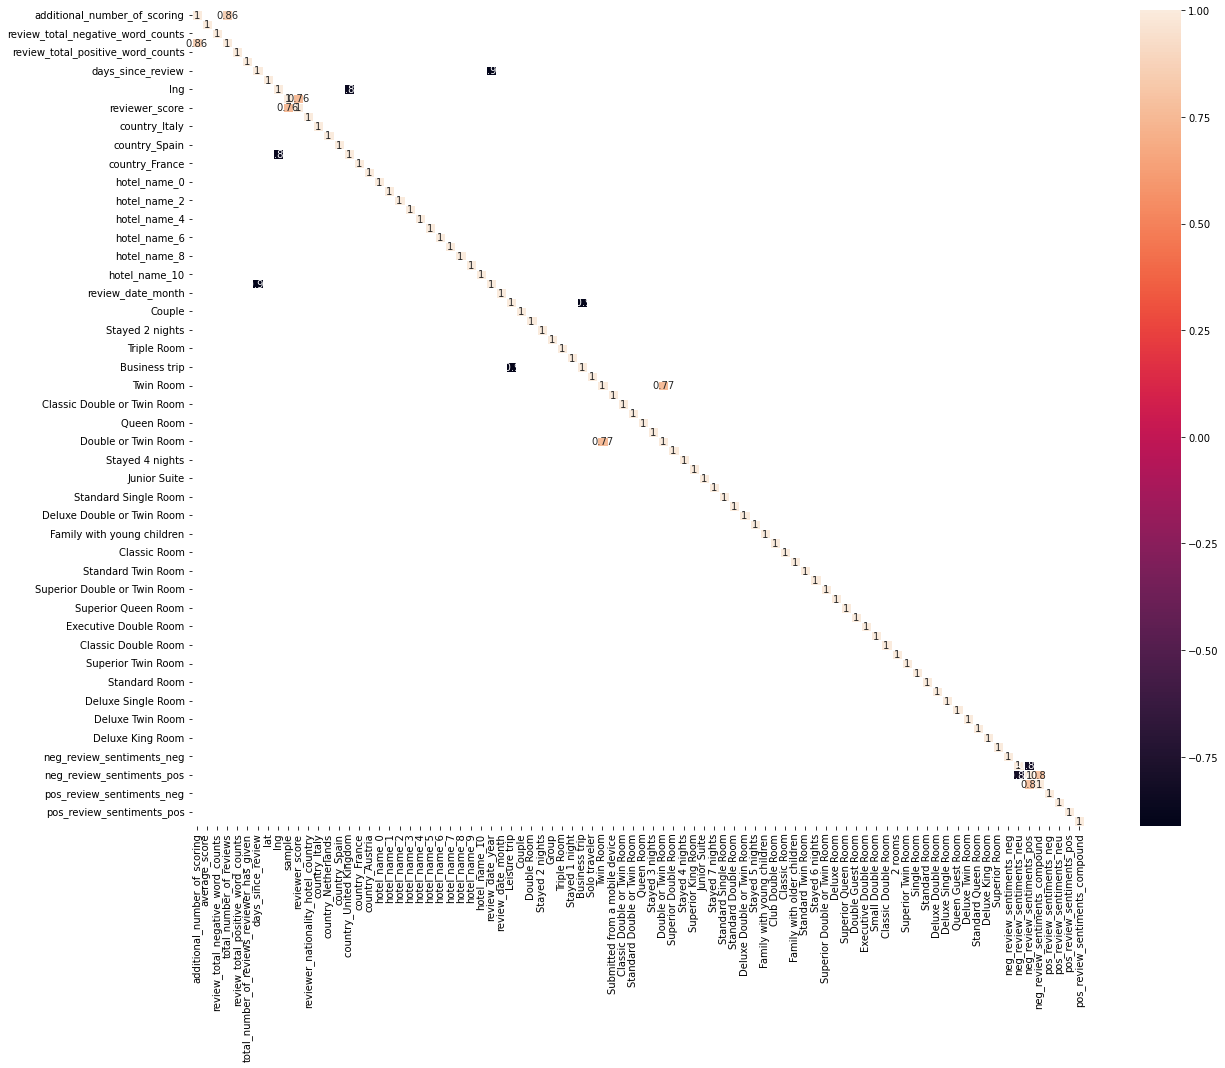

In [60]:
# проверим на мультиколлениарность


fig, ax = plt.subplots(figsize=(20,15))
corr_df = data.corr(method='spearman')

# Отобразим корреляцию выше 75%.
sns.heatmap(corr_df[abs(corr_df) >= 0.75], annot=True, linewidths=.5, ax=ax)

Оченка значимости признака 

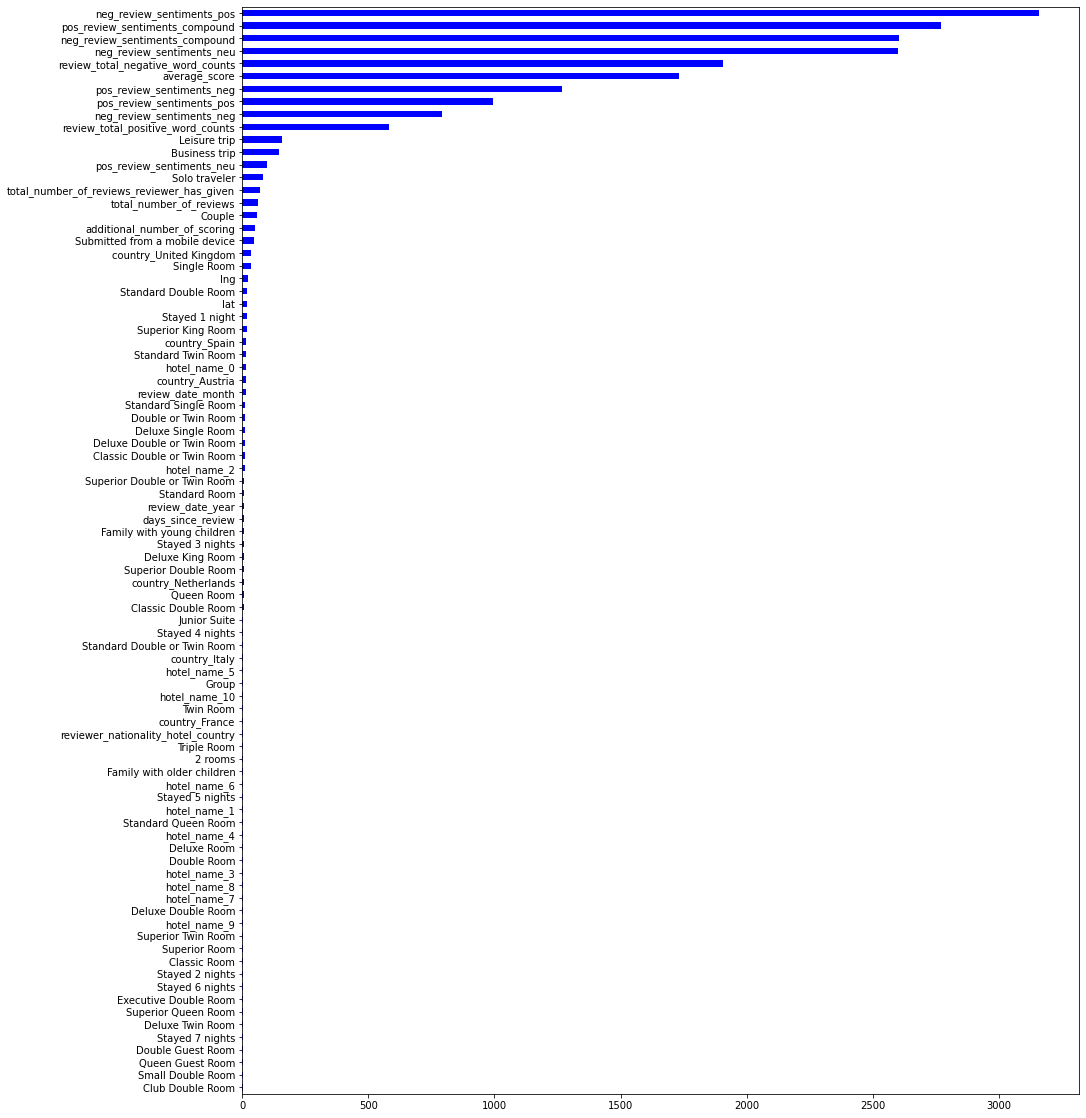

In [61]:

# ANOVA тест для оценки значимости числовых признаков
y = data.query('sample == 1').drop(['sample'], axis=1)['reviewer_score'].values
X = data.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='blue');



In [62]:


# Удаленеие признаков с высокой корреляцией.
data.drop(['additional_number_of_scoring', 'Twin Room', 'Business trip', 'days_since_review', 'neg_review_sentiments_neu'], axis = 1, inplace=True)



<AxesSubplot:>

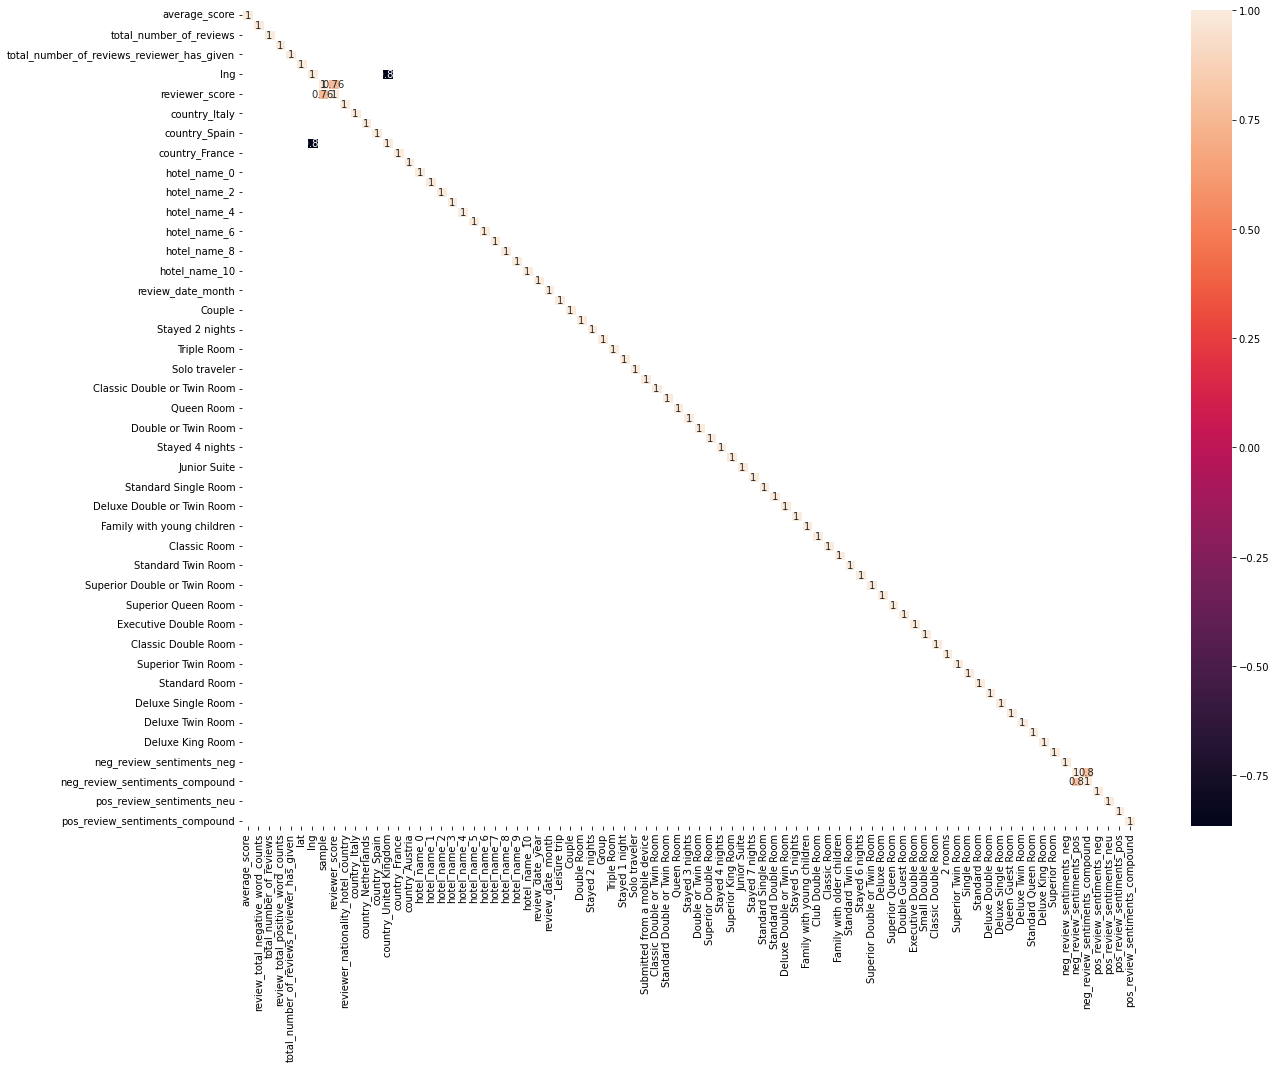

In [63]:
# повторный анализ на корреляцию


fig, ax = plt.subplots(figsize=(20,15))
corr_df = data.corr(method='spearman')

# Отобразим корреляцию выше 75%.
sns.heatmap(corr_df[abs(corr_df) >= 0.75], annot=True, linewidths=.5, ax=ax)

In [64]:
# Удаленеие признаков с высокой корреляцией. ЭКСПЕРИМЕНТ
#data.drop(['neg_review_sentiments_pos'], axis = 1, inplace=True)
# Экспериментально установлено, что этот признак лучше оставить

## 3. Нормализация

<AxesSubplot:xlabel='review_total_positive_word_counts', ylabel='Count'>

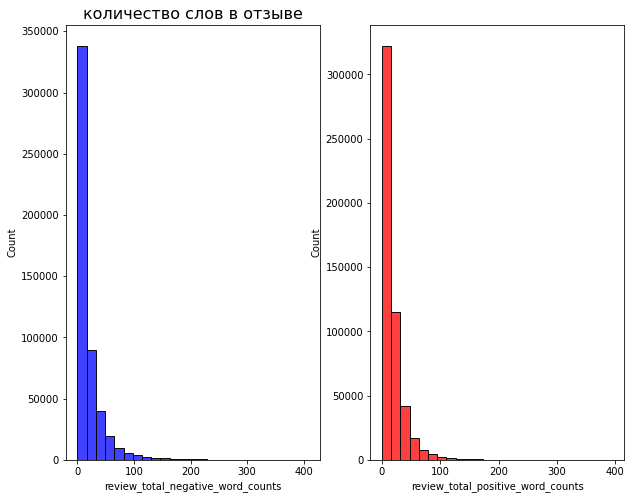

In [65]:

#визуализация признаков

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
sns.histplot(
    data=data,
    x='review_total_negative_word_counts',
    bins=25,
    color='blue',
    ax=axes[0]
)
axes[0].set_title('количество слов в отзыве', fontsize=16)
sns.histplot(
    data=data,
    x='review_total_positive_word_counts',
    bins=25,
    color='red',
    ax=axes[1]
)

<AxesSubplot:xlabel='total_number_of_reviews_reviewer_has_given', ylabel='Count'>

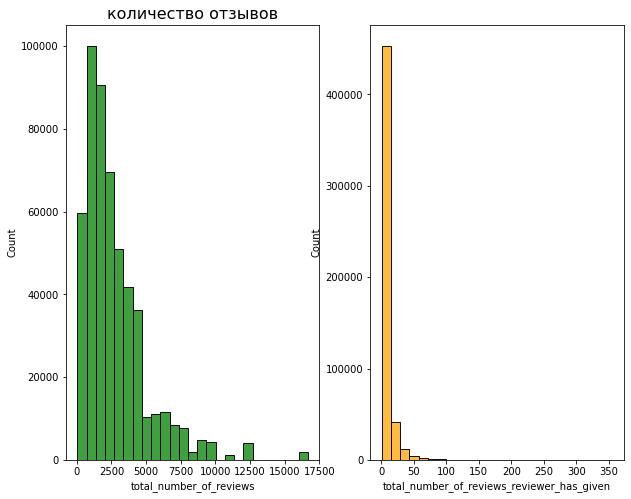

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
sns.histplot(
    data=data,
    x='total_number_of_reviews',
    bins=25,
    color='green',
    ax=axes[0]
)
axes[0].set_title('количество отзывов', fontsize=16)
sns.histplot(
    data=data,
    x='total_number_of_reviews_reviewer_has_given',
    bins=25,
    color='orange',
    ax=axes[1]
)

## 3.1 Проверка на ошибки

<AxesSubplot:title={'center':'neg_review_sentiments_compound'}, ylabel='Frequency'>

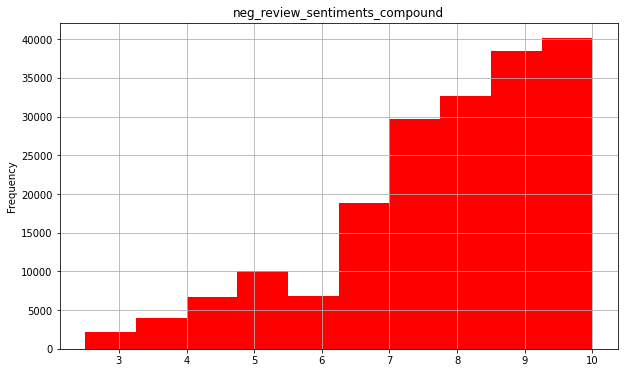

In [67]:
#pd.reset_option('display.max_rows')
# посмотрим насколько распределение баллов соответсвует слабым негативным отзывам 
n_data = data[ (data['neg_review_sentiments_compound'] <= 0) & (data['sample']  == 1)]['reviewer_score']

n_data.plot(
    kind='hist',
    figsize=(10, 6),
    title='neg_review_sentiments_compound',
    grid = True,
    color = 'red',
    bins=10
)



<AxesSubplot:title={'center':'pos_review_sentiments_compound'}, ylabel='Frequency'>

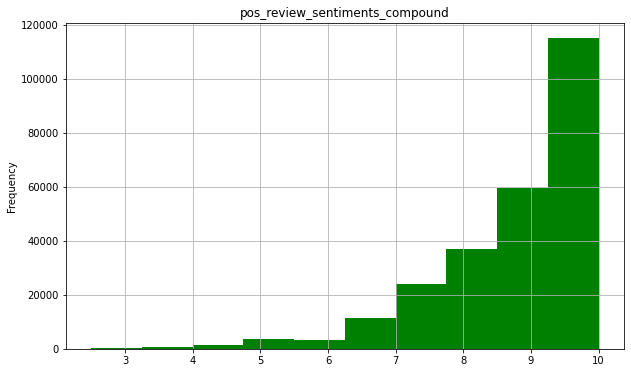

In [68]:
# посмотрим насколько распределение баллов соответсвует сильным  позитивным  отзывам 
p_data = data[(data['pos_review_sentiments_compound'] >= 0.5) & (data['sample']  == 1) ]['reviewer_score']

p_data.plot(
    kind='hist',
    figsize=(10, 6),
    title='pos_review_sentiments_compound',
    grid = True,
    color = 'green',
    bins=10
)



In [69]:
pd.reset_option('display.max_rows')
data

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score,reviewer_nationality_hotel_country,...,Standard Queen Room,Deluxe King Room,Superior Room,neg_review_sentiments_neg,neg_review_sentiments_pos,neg_review_sentiments_compound,pos_review_sentiments_neg,pos_review_sentiments_neu,pos_review_sentiments_pos,pos_review_sentiments_compound
0,8.1,52,16670,62,1,45.533137,9.171102,0,0.0,0,...,0,0,0,0.129,0.125,-0.0554,0.000,0.671,0.329,0.9615
1,8.6,10,5018,0,7,52.385649,4.834443,0,0.0,0,...,0,0,0,0.216,0.000,-0.2960,1.000,0.000,0.000,-0.5719
2,8.3,3,351,5,15,41.393192,2.161520,0,0.0,0,...,0,0,0,0.000,0.000,0.0000,0.000,0.260,0.740,0.6908
3,9.1,0,1543,27,9,45.479888,9.196298,0,0.0,0,...,0,0,0,0.000,1.000,0.5574,0.000,0.457,0.543,0.9794
4,9.1,0,4687,7,2,52.370545,4.888644,0,0.0,0,...,0,0,0,0.000,1.000,0.5574,0.000,0.230,0.770,0.7717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,9.0,0,617,10,10,51.494028,-0.191050,1,8.8,0,...,0,0,0,0.000,1.000,0.5574,0.000,1.000,0.000,0.0000
515734,8.4,0,3224,93,1,48.192379,16.399451,1,9.2,0,...,0,0,0,0.000,1.000,0.5574,0.045,0.857,0.098,0.7264
515735,6.8,12,2751,9,21,51.520795,-0.131084,1,8.3,0,...,0,0,0,0.155,0.000,-0.1646,0.000,0.465,0.535,0.7845
515736,8.1,0,1567,6,28,51.515125,-0.160066,1,9.2,0,...,0,0,0,0.000,1.000,0.5574,0.000,1.000,0.000,0.0000


In [70]:
# признаки распределены ненормально, нормализуем их

from sklearn import preprocessing

# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()
data_r = data[['review_total_negative_word_counts','review_total_positive_word_counts','total_number_of_reviews','total_number_of_reviews_reviewer_has_given'] ]
# кодируем исходный датасет
df_r = r_scaler.fit_transform(data_r)
col_names = data_r.columns
# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_r = pd.DataFrame(df_r, columns=col_names)

In [71]:
# заменим значения в исходном data
data['review_total_negative_word_counts'] = df_r['review_total_negative_word_counts']
data['review_total_positive_word_counts'] = df_r['review_total_positive_word_counts']
data['total_number_of_reviews'] = df_r['total_number_of_reviews']
data['total_number_of_reviews_reviewer_has_given'] = df_r['total_number_of_reviews_reviewer_has_given']

<AxesSubplot:xlabel='total_number_of_reviews_reviewer_has_given', ylabel='Count'>

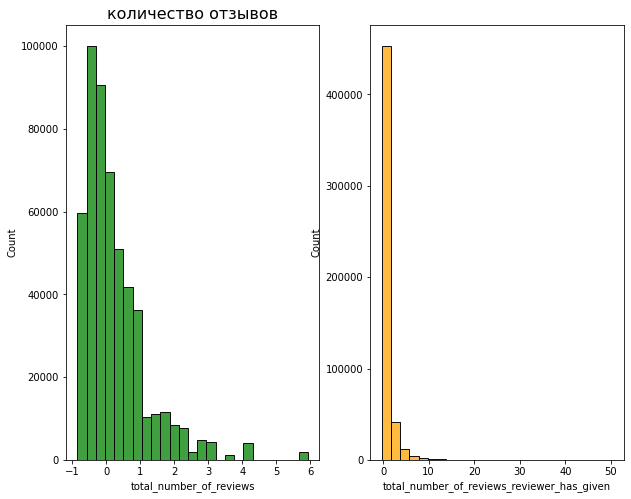

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
sns.histplot(
    data=data,
    x='total_number_of_reviews',
    bins=25,
    color='green',
    ax=axes[0]
)
axes[0].set_title('количество отзывов', fontsize=16)
sns.histplot(
    data=data,
    x='total_number_of_reviews_reviewer_has_given',
    bins=25,
    color='orange',
    ax=axes[1]
)

## 4. Обучение модели

In [73]:

# выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)



In [74]:
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [75]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape


((128935, 82), (386803, 82), (386803, 81), (309442, 81), (77361, 81))

In [76]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [77]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


In [78]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.8553027412606692


<AxesSubplot:>

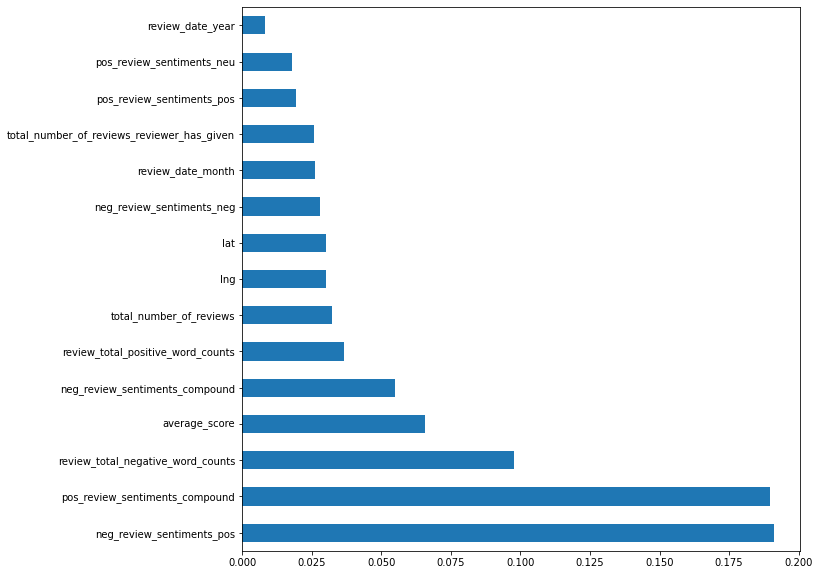

In [79]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [80]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,reviewer_nationality_hotel_country,country_Italy,...,Standard Queen Room,Deluxe King Room,Superior Room,neg_review_sentiments_neg,neg_review_sentiments_pos,neg_review_sentiments_compound,pos_review_sentiments_neg,pos_review_sentiments_neu,pos_review_sentiments_pos,pos_review_sentiments_compound
16951,8.6,-0.142857,-0.619086,0.176471,0.714286,48.853688,2.332267,0.0,0,0,...,0,0,1,0.000,0.000,0.0000,0.0,0.380,0.620,0.9195
107974,8.5,-0.333333,0.598695,0.000000,0.000000,41.381222,2.173962,0.0,0,0,...,0,0,0,0.000,1.000,0.9325,0.0,0.684,0.316,0.5719
120099,8.4,1.476190,0.724715,0.470588,0.000000,52.376752,4.904618,0.0,0,0,...,0,0,0,0.000,0.276,0.8957,0.0,0.814,0.186,0.4927
71613,8.1,0.857143,3.031811,0.117647,0.714286,51.511099,-0.120867,0.0,0,0,...,0,0,0,0.222,0.000,-0.7184,0.0,0.662,0.338,0.5574
73770,7.4,0.000000,-0.505302,-0.411765,7.571429,51.499279,-0.197359,0.0,0,0,...,0,0,0,0.276,0.000,-0.3167,0.0,1.000,0.000,0.0000
107004,7.7,0.571429,-0.365416,-0.352941,6.285714,48.210736,16.382147,0.0,0,0,...,0,0,0,0.103,0.099,-0.0258,0.0,0.253,0.747,0.7096
53253,7.9,0.904762,0.787520,0.352941,-0.285714,51.516288,-0.172108,0.0,0,0,...,0,0,0,0.000,0.196,0.7040,0.0,0.663,0.337,0.7650
125960,8.5,0.333333,0.234095,0.529412,-0.142857,41.368437,2.190153,0.0,0,0,...,0,0,0,0.000,0.288,0.7684,0.0,0.421,0.579,0.9575
51301,9.2,-0.428571,-0.515498,4.117647,0.142857,52.370835,4.895403,0.0,0,0,...,0,0,1,0.000,1.000,0.5574,0.0,0.714,0.286,0.9803
106488,8.8,0.809524,-0.134176,-0.352941,0.000000,51.474469,-0.019428,0.0,0,0,...,0,0,0,0.280,0.000,-0.8211,0.0,0.204,0.796,0.8316


In [81]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [82]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [83]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.4s finished


In [84]:
predict_submission

array([8.819, 7.094, 8.229, ..., 8.475, 9.557, 7.001])

In [85]:
list(sample_submission)

['reviewer_score', 'id']

In [86]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.819,488440
1,7.094,274649
2,8.229,374688
3,9.750,404352
4,9.574,451596
5,8.935,302161
6,7.470,317079
7,7.724,13963
8,8.433,159785
9,7.410,195089
